# Preparing data

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxopt
from cvxopt import matrix, solvers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
files_path=['/content/drive/MyDrive/Flame.txt','/content/drive/MyDrive/Aggregation.txt','/content/drive/MyDrive/Jain.txt',
            '/content/drive/MyDrive/Compound.txt','/content/drive/MyDrive/Pathbased.txt','/content/drive/MyDrive/Spiral.txt']

In [12]:
files_path[0]

'/content/drive/MyDrive/Flame.txt'

# **Bonus Datasets**

In [5]:
def rbf_kernel(X, Y=None,gamma=0.1):
        if Y is None:
            Y = X

        kernel_matrix = np.zeros((X.shape[0], Y.shape[0]))
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                kernel_matrix[i, j] = np.exp(-gamma * np.linalg.norm(x - y)**2)

        return kernel_matrix

In [6]:
class SVM_GD:
    def __init__(self, C=10, gamma=0.1, kernel="rbf"):
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.W = None
        self.b = 0.

    def rbf_kernel(self, x1, x):
        m = x.shape[0]
        n = x1.shape[0]
        op = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                op[i, j] = np.exp(-np.sum((x1[i] - x[j]) ** 2) / (2 * self.gamma))
        return op

    def fit(self, x_train, y_train, epochs=100, learning_rate=0.01):
        y = y_train.copy()
        x = x_train.copy()
        self.initial = x.copy()

        if self.kernel == "rbf":
            x = self.rbf_kernel(x, x)
            m = x.shape[0]
            self.W = np.zeros(m)

        n = x.shape[0]

        for epoch in range(epochs):
            y_hat = np.dot(x, self.W) + self.b
            grad_W = (-self.C * np.multiply(y, x.T).T + self.W).T

            for weight in range(self.W.shape[0]):
                grad_W[weight] = np.where(1 - y_hat <= 0, self.W[weight], grad_W[weight])

            grad_W = np.sum(grad_W, axis=1)
            self.W -= learning_rate * grad_W / n
            grad_b = -y * self.b
            grad_b = np.where(1 - y_hat <= 0, 0, grad_b)
            grad_b = np.sum(grad_b)
            self.b -= grad_b * learning_rate / n

    def evaluate(self, x, y):
        pred = self.predict(x)
        diff = np.abs(np.where(y == -1, 0, 1) - pred)
        return ((len(diff) - sum(diff)) / len(diff))

    def predict(self, x):
        if self.kernel == "rbf":
            x = self.rbf_kernel(x, self.initial)
            print("W: ",self.W)
        return np.where(np.dot(x, self.W) + self.b > 0, 1, -1)

In [15]:
class SVM:
    def __init__(self, C=10):
        self.C = C
        self.W = None
        self.b = 0.
        self.support_vectors = None

    def fit(self, x_train, y_train):
        c = self.C
        self.initial = x_train.copy()

        P = cvxopt.matrix((np.dot(y_train.reshape(-1, 1), y_train.reshape(1, -1)) * rbf_kernel(x_train)))
        q = cvxopt.matrix(-np.ones((len(y_train), 1)))
        G = cvxopt.matrix(np.vstack((np.eye(len(y_train)) * -1, np.eye(len(y_train)))))
        h = cvxopt.matrix(np.hstack((np.zeros(len(y_train)), np.ones(len(y_train)) * c)))
        A = cvxopt.matrix(y_train, (1, len(y_train)),'d')
        b = cvxopt.matrix(0.0)
        solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        alphas = np.array(solution['x'])
        # print("len alphas ",len(alphas))
        # Calculate W and b
        W = np.sum(alphas.reshape(-1, 1) * y_train.reshape(-1, 1) * x_train, axis=1)
        positive_list = rbf_kernel(x_train[np.where(y_train == 1)], W)
        negative_list = rbf_kernel(x_train[np.where(y_train == -1)], W)
        b = -0.5 * (np.min(positive_list) + np.max(negative_list))

        # self.W = np.append(W, b)
        self.W = W
        self.b = b

    def evaluate(self, x, y):
        pred = self.predict(x)
        # print("PRED: ",(pred))
        # print("Y: ",np.where(y == -1, 0, 1))
        diff = np.abs(np.where(y == -1, 0, 1) - pred)
        return ((len(diff) - sum(diff)) / len(diff))

    def predict(self, x):
        # x = np.c_[x, np.ones(x.shape[0])]
        # print("Shape X: ",x.shape)
        # print("W: ",self.W)
        x = rbf_kernel(x, self.initial)
        return np.where(np.dot(x, self.W) > 0, 1, 0)

In [8]:
def SVM_general(df):
    unique_classes = df['Y'].unique()
    models = {}
    accuracies_train = {}
    accuracies_test = {}

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink']

    plt.figure(figsize=(8, 6))

    for idx, cls in enumerate(unique_classes):
        df_class = df.copy()
        df_class['Y'] = np.where(df_class['Y'] == cls, 1, -1)

        x_train = df_class[['X1', 'X2']].sample(frac=0.8, random_state=42)
        y_train = df_class.loc[x_train.index, 'Y']
        x_test = df_class[['X1', 'X2']].drop(x_train.index)
        y_test = df_class.loc[x_test.index, 'Y']

        svm = SVM()
        svm.fit(x_train.values, y_train.values)

        train_accuracy = svm.evaluate(x_train.values, y_train.values)
        test_accuracy = svm.evaluate(x_test.values, y_test.values)
        accuracies_train[cls] = train_accuracy
        accuracies_test[cls] = test_accuracy

        models[cls] = svm

        # Filter points classified as positive (predicted class label = 1)
        positive_indices_train = np.where(svm.predict(x_train.values) == 1)[0]
        x_train_positive = x_train.iloc[positive_indices_train]

        positive_indices_test = np.where(svm.predict(x_test.values) == 1)[0]
        x_test_positive = x_test.iloc[positive_indices_test]

        max_X1 = df['X1'].max()
        max_X2 = df['X2'].max()

        combinations = []
        for x1 in range(int(max_X1)+3):
            for x2 in range(int(max_X2)+3):
                combinations.append({'X1': x1, 'X2': x2})

        max_values_df = pd.DataFrame(combinations)

        predictions_max_values = svm.predict(max_values_df.values)
        max_values_df_positive = max_values_df[predictions_max_values == 1]

        plt.scatter(x_train_positive['X1'], x_train_positive['X2'], c=colors[idx], label=f"Class {cls}",s=40)
        plt.scatter(x_test_positive['X1'], x_test_positive['X2'], c=colors[idx],s=40)
        plt.scatter(max_values_df_positive['X1'], max_values_df_positive['X2'], c=colors[idx], s=10)

    plt.title('Predicted points')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

    return models, accuracies_train, accuracies_test

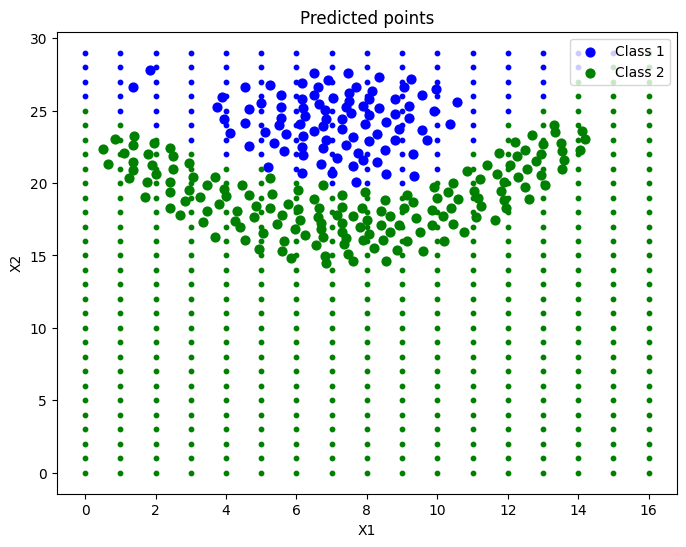

Class 1: Train Accuracy = 99.48%, Test Accuracy = 97.92%
Class 2: Train Accuracy = 99.48%, Test Accuracy = 97.92%


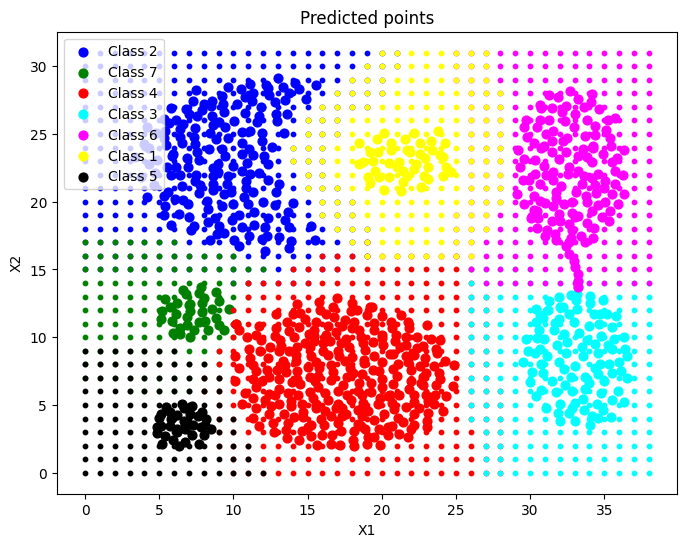

Class 2: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 7: Train Accuracy = 99.84%, Test Accuracy = 100.00%
Class 4: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 3: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 6: Train Accuracy = 99.84%, Test Accuracy = 99.37%
Class 1: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 5: Train Accuracy = 100.00%, Test Accuracy = 100.00%


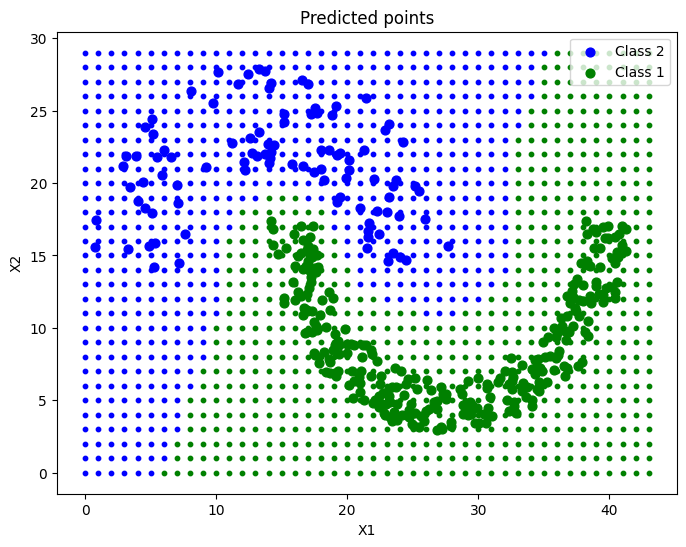

Class 2: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 1: Train Accuracy = 100.00%, Test Accuracy = 100.00%


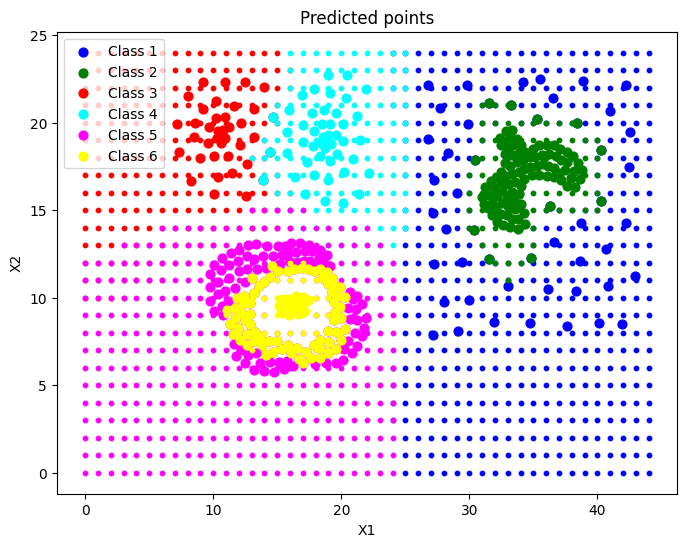

Class 1: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 2: Train Accuracy = 96.55%, Test Accuracy = 100.00%
Class 3: Train Accuracy = 99.69%, Test Accuracy = 100.00%
Class 4: Train Accuracy = 99.37%, Test Accuracy = 100.00%
Class 5: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 6: Train Accuracy = 81.82%, Test Accuracy = 83.75%


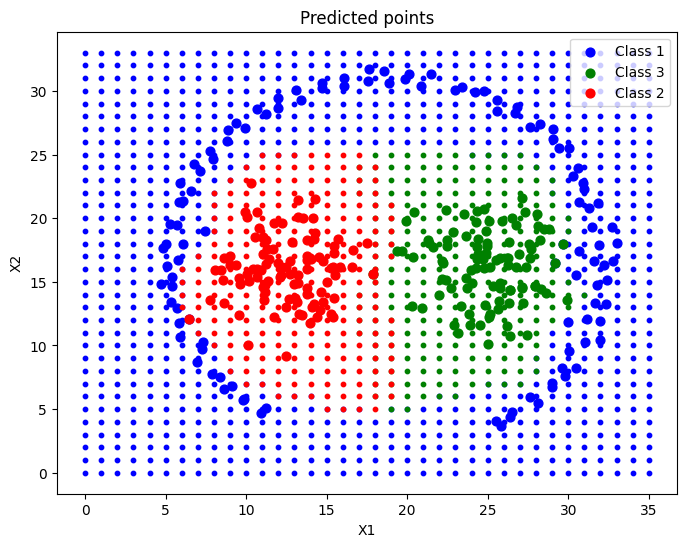

Class 1: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 3: Train Accuracy = 100.00%, Test Accuracy = 95.00%
Class 2: Train Accuracy = 100.00%, Test Accuracy = 98.33%


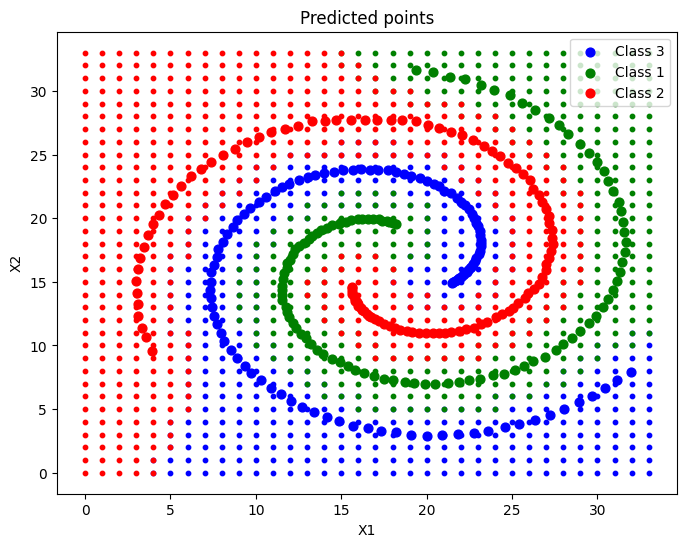

Class 3: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 1: Train Accuracy = 100.00%, Test Accuracy = 100.00%
Class 2: Train Accuracy = 100.00%, Test Accuracy = 100.00%


In [16]:
for file_path in files_path:
  df = pd.read_csv(file_path, skiprows=7, delimiter='\t', header=None)
  df = df.iloc[:, :3]
  df.columns = ['X1', 'X2', 'Y']

  # Train models, plot points classified as positive with different colors for each class, and print accuracies
  models, accuracies_train, accuracies_test = SVM_general(df)

  # Print accuracies
  for cls, acc_train in accuracies_train.items():
      acc_test = accuracies_test[cls]
      class_label = 'Class ' + str(cls)
      print(f"{class_label:<5}: Train Accuracy = {acc_train*100:.2f}%, Test Accuracy = {acc_test*100:.2f}%")